In [71]:
%run PVModel_functions.ipynb

In [72]:
%run PVsystem_filterfunction_jack-may.ipynb

In [73]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
from pvlib import pvsystem
import pvanalytics
import math
import pvpltools
import seaborn as sns
import sklearn
import statistics
from sklearn.metrics import r2_score
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=24
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [74]:
mod_names = 'LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar'#, 'Jinko'
mettablename = 'dbo.SNLA_Met_DataOut'

In [75]:
#Generate an empty df to store appended results
tempresults = []

In [76]:
for mod_name in mod_names:
    
    
    #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]
    systablename = module['table_name']
    start = '2021-01-01 00:00:00-07:00'
    end = '2021-07-27 00:00:00-07:00'
    
    #Import sys & met databases & merge into one df
    df = sys_met_data(mettablename, systablename, start, end)
    
    #Filter out erroneous temperature and wind speed measurements
    df = simple_filter(sys=df, variable='Temp_C_Avg', lower=-40, upper=60, apply=True)
    df = simple_filter(sys=df, variable='WS_ms_Mean', lower= 0,  upper=32, apply=True)
    
    all_rtd = ['LG', 'Panasonic']
    twth_rtd = ['HanQPlus', 'HanQPeak']
    onfo_rtd = ['Can 270', 'Can275']
    
    
    #for modules with all rtds present
    if mod_name in all_rtd:
        
        #filter out of bounds rtd measurements
        df = simple_filter(sys=df, variable=module['str_1_rtd'], lower=-15, upper=80, apply=True)
        df = simple_filter(sys=df, variable=module['str_2_rtd'], lower=-15, upper=80, apply=True)
        df = simple_filter(sys=df, variable=module['str_3_rtd'], lower=-15, upper=80, apply=True)
        df = simple_filter(sys=df, variable=module['str_4_rtd'], lower=-15, upper=80, apply=True)
        
        #calculate mean and median rtd values
        df['Mean RTD'] = ((df[module['str_1_rtd']]+df[module['str_2_rtd']]+df[module['str_3_rtd']]+df[module['str_4_rtd']])/4)
        rtds = pd.DataFrame(df[module['str_1_rtd']])
        rtds[module['str_2_rtd']] = df[module['str_2_rtd']]
        rtds[module['str_3_rtd']] = df[module['str_3_rtd']]
        rtds[module['str_4_rtd']] = df[module['str_4_rtd']]
        df['Median RTD'] = rtds.median(axis=1)
        
    #for modules with only strings 2 and 3 rtds present    
    elif mod_name in twth_rtd:
        
        #filter out of bounds rtd measurements
        df = simple_filter(sys=df, variable=module['str_2_rtd'], lower=-15, upper=80, apply=True)
        df = simple_filter(sys=df, variable=module['str_3_rtd'], lower=-15, upper=80, apply=True)
        
        #calculate mean and median rtd values
        df['Mean RTD'] = ((df[module['str_2_rtd']]+df[module['str_3_rtd']])/2)
        rtds = pd.DataFrame(df[module['str_2_rtd']])
        rtds[module['str_3_rtd']] = df[module['str_3_rtd']]
        df['Median RTD'] = rtds.median(axis=1)
    
    
    #for modules with only strings 1 and 3 rtds present
    else:
        
        #filter out of bounds rtd measurement
        df = simple_filter(sys=df, variable=module['str_1_rtd'], lower=-15, upper=80, apply=True)
        df = simple_filter(sys=df, variable=module['str_4_rtd'], lower=-15, upper=80, apply=True)
        
        #calculate mean and median rtd values
        df['Mean RTD'] = ((df[module['str_1_rtd']]+df[module['str_4_rtd']])/2)
        rtds = pd.DataFrame(df[module['str_1_rtd']])
        rtds[module['str_4_rtd']] = df[module['str_4_rtd']]
        df['Median RTD'] = rtds.median(axis=1)
    
    
    #Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
    pres = df['Pressure_mBar_Avg']*100
    sdf = calc_sol_data(time=df.index, latitude=module['latitude'], longitude=module['longitude'],
                    temperature=df['Temp_C_Avg'], tilt=module['tilt'], altitude=module['altitude'])
    #Calculate Environmental Data i.e. airmass, pressure, POA irradiance compenents etc.
    edf = calc_env_data(tilt=module['tilt'],altitude=module['altitude'], sur_azimuth=module['surface_azimuth'], 
                    sol_azimuth=sdf['azimuth'], zenith=sdf['apparent_zenith'], DNI=df['Direct_Wm2_Avg'], 
                    GHI=df['Global_Wm2_Avg'], DHI=df['Diffuse_Wm2_Avg'], DNI_extra=sdf['dni_extra'], model ='haydavies')
    
    #filter out of bounds poa irradiance
    edf = simple_filter(sys=edf, variable='poa_global', lower=0, upper=1300, apply=True)
    
    
    
    ###BEGIN TEMPERATURE MODEL CALCULATIONS
    
    #sapm_tcell
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    tcell_sapm = pvlib.temperature.sapm_cell(poa_global=edf['poa_global'], temp_air=df.Temp_C_Avg, wind_speed=df.WS_ms_Mean,
                                        **temperature_model_parameters).to_frame()
    tcell_sapm['Model'] = 'sapm_cell'
    tcell_sapm['Mean RTD'] = df['Mean RTD']
    tcell_sapm['Median RTD'] = df['Median RTD']
    tcell_sapm['Year'] = tcell_sapm.index.year
    tcell_sapm['TmStamp'] = tcell_sapm.index
    tcell_sapm['System'] = mod_name
    tempresults.append(tcell_sapm) 
    

    #pvsyst_tcell
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['pvsyst']['freestanding']
    tcell_pvsyst = pvlib.temperature.pvsyst_cell(poa_global=edf['poa_global'], temp_air=df.Temp_C_Avg, wind_speed=df.WS_ms_Mean,                                           
                                                 **temperature_model_parameters).to_frame()
    tcell_pvsyst['Model']='pvsyst_cell'
    tcell_pvsyst['Mean RTD'] = df['Mean RTD']
    tcell_pvsyst['Median RTD'] = df['Median RTD']
    tcell_pvsyst['Year'] = tcell_pvsyst.index.year
    tcell_pvsyst['TmStamp'] = tcell_pvsyst.index
    tcell_pvsyst['System'] = mod_name
    tempresults.append(tcell_pvsyst)
    
    
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    mod_sapm = pvlib.temperature.sapm_module(poa_global=edf['poa_global'], temp_air=df.Temp_C_Avg, wind_speed=df.WS_ms_Mean,
                                        a=temperature_model_parameters['a'], b=temperature_model_parameters['b']).to_frame()
    mod_sapm['Model'] = 'sapm_mod'
    mod_sapm['Mean RTD'] = df['Mean RTD']
    mod_sapm['Median RTD'] = df['Median RTD']
    mod_sapm['Year'] = mod_sapm.index.year
    mod_sapm['TmStamp'] = mod_sapm.index
    mod_sapm['System'] = mod_name
    tempresults.append(mod_sapm)

    #faiman
    tcell_faiman = pvlib.temperature.faiman(poa_global=edf['poa_global'], temp_air=df.Temp_C_Avg, wind_speed=df.WS_ms_Mean,
                                       u0=module['U0'], u1=module['U1']).to_frame()
    tcell_faiman['Model']='faiman'
    tcell_faiman['Mean RTD'] = df['Mean RTD']
    tcell_faiman['Median RTD'] = df['Median RTD']
    tcell_faiman['Year'] = tcell_faiman.index.year
    tcell_faiman['TmStamp']=tcell_faiman.index
    tcell_faiman['System'] = mod_name
    tempresults.append(tcell_faiman)
    
    #ross_tcell
    tcell_ross = pvlib.temperature.ross(poa_global=edf['poa_global'], temp_air=df.Temp_C_Avg, noct=module['noct']).to_frame()
    tcell_ross['Model'] = 'ross'
    tcell_ross['Mean RTD'] = df['Mean RTD']
    tcell_ross['Median RTD'] = df['Median RTD']
    tcell_ross['Year'] = tcell_ross.index.year
    tcell_ross['TmStamp'] = tcell_ross.index
    tcell_ross['System'] = mod_name
    tempresults.append(tcell_ross)
    
     #sapm_mod2cell
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    mod2cell_sapm = pvlib.temperature.sapm_cell_from_module(module_temperature=df['Median RTD'], poa_global=edf['poa_global'], deltaT=temperature_model_parameters['deltaT']).to_frame()
    mod2cell_sapm['Model'] = 'sapm_mod2cell'
    mod2cell_sapm['Mean RTD'] = df['Mean RTD']
    mod2cell_sapm['Median RTD'] = df['Median RTD']
    mod2cell_sapm['Year'] = mod2cell_sapm.index.year
    mod2cell_sapm['TmStamp'] = mod2cell_sapm.index
    mod2cell_sapm['System'] = mod_name
    tempresults.append(mod2cell_sapm)
    
    #print module name after each iteration so current system is known
    print(mod_name)

LG
Panasonic
Can270
Can275
HanQPlus
HanQPeak
MissionSolar


In [36]:
temperature_model_parameters

{'a': -3.56, 'b': -0.075, 'deltaT': 3}

In [77]:
temp_model_results = pd.concat(tempresults, ignore_index=True)
temp_model_results.index = temp_model_results['TmStamp']
temp_model_results.rename(columns ={0 : 'Modeled Temperature'}, inplace=True)

In [78]:
temp_model_results['Difference'] =temp_model_results['Modeled Temperature']-temp_model_results['Median RTD']

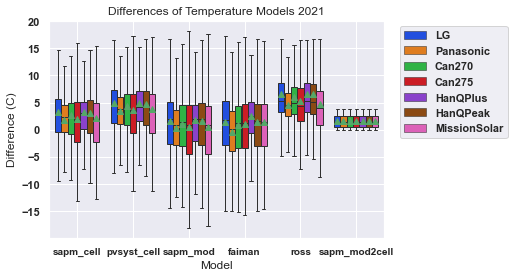

In [79]:
ax = sns.boxplot(x='Model', y='Difference', data = temp_model_results, hue='System', showmeans=True, showfliers=False,palette='bright')
ax.grid(True)
sns.set(rc={'figure.figsize':(10,7.5)})
#ax.set_ylim([0,5])
ax.set_title('Differences of Temperature Models 2021')
ax.set_ylabel('Difference (C)')
ax.legend(bbox_to_anchor= (1.03, 1))

In [80]:
temp_model_results_can270 = temp_model_results.loc[temp_model_results['System']=='Can270']

Text(0.5, 1.0, 'Measured v Modeled Temperatures Can270')

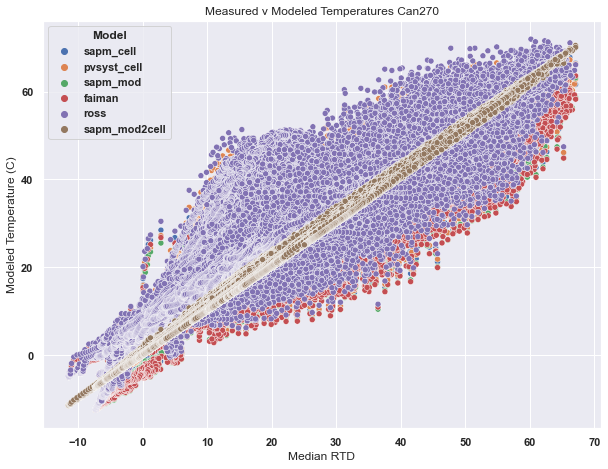

In [81]:

ax = sns.scatterplot(x='Median RTD', y='Modeled Temperature', hue='Model', data=temp_model_results_can270)
ax.set_xlabel('Median RTD')
ax.set_ylabel('Modeled Temperature (C)')
ax.set_title('Measured v Modeled Temperatures Can270')